In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad 

In [2]:
#Define final time, time step and epsilon
T = 1
dt = 0.0005
epsilon = 0.0025
Nt = int(np.ceil(T/dt))

In [3]:
#Define plus function to generate splines.
def plus(x,n):
    return x**n*(x>=0)

In [4]:
#Define cubic spline through the plus functions, ensure the compact support is enforced aswell, particularly important for t>(i+2)*dt 
def cubic_spline(t,dt,i):
    ans = (plus((t-(i-2)*dt),3)-4*plus((t-(i-1)*dt),3)+6*plus((t-(i)*dt),3)-4*plus((t-(i+1)*dt),3)+plus((t-(i+2)*dt),3))*(t<=(i+2)*dt)*(t>=(i-2)*dt)
    return 1/(4*dt**3)*ans

#Same for second derivative
def second_deriv_cubic_spline(t,dt,i):
    ans = (6*plus(t-(i-2)*dt,1)-24*plus(t-(i-1)*dt,1)+36*plus(t-i*dt,1)-24*plus(t-(i+1)*dt,1)+6*plus(t-(i+2)*dt,1))*(t<=(i+2)*dt)*(t>=(i-2)*dt)
    return 1/(4*dt**3)*ans

In [5]:
#Generate mass matrix
#Numbers are so small that relative error is more important than absolute error. Therefore the absolute error tolerance is set very small so that in practice the relative error is the criteria used
#Main diagonal
#Functions overlap is on [(j-2)dt,(j+2)dt]
M_i_i = np.zeros(Nt-1)
for j in range(2,Nt-1):
    M_i_i[j-2] = quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,j)*cubic_spline(x,dt,j),(j-2)*dt,(j+2)*dt,points=[(j-1)*dt,j*dt,(j+1)*dt],epsabs=1e-50,epsrel=1e-10)[0]

M_i_i[-2] = quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,Nt-1)*cubic_spline(x,dt,Nt-1),T-3*dt,T,points=[T-2*dt,T-dt],epsabs=1e-50,epsrel=1e-10)[0]
M_i_i[-1] = quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,Nt)*cubic_spline(x,dt,Nt),T-2*dt,T,points=[T-dt],epsabs=1e-50,epsrel=1e-10)[0]



#First off diagonal
#Functions overlap is on [(j-1)dt,(j+2)dt]
M_i_i_plus_1 = np.zeros(Nt-2)
for j in range(2,Nt-2):
    M_i_i_plus_1[j-1] = quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,j)*cubic_spline(x,dt,j+1),(j-1)*dt,(j+2)*dt,points=[j*dt,(j+1)*dt],epsabs=1e-50,epsrel=1e-10)[0]

#Only the overlap of the last entry partially lies outside of [0,T]
M_i_i_plus_1[-1] = quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,Nt-1)*cubic_spline(x,dt,Nt),T-2*dt,T,points=[T-dt],epsabs=1e-50,epsrel=1e-10)[0]



#Second off diagonal
#Functions overlap is on [jdt,(j+2)dt]
M_i_i_plus_2 = np.zeros(Nt-3)
for j in range(2,Nt-1):
    M_i_i_plus_2[j-2] = quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,j)*cubic_spline(x,dt,j+2),(j)*dt,(j+2)*dt,points=[(j+1)*dt],epsabs=1e-50,epsrel=1e-10)[0]

#Dont need to split out the last 2 cases as the overlap lies entirely within [0,T]


#Third off diagonal
#Functions overlap is on [(j+1)dt,(j+2)dt]
M_i_i_plus_3 = np.zeros(Nt-4)
for j in range(2,Nt-2):
    M_i_i_plus_3[j-2] = quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,j)*cubic_spline(x,dt,j+3),(j+1)*dt,(j+2)*dt,epsabs=1e-50,epsrel=1e-10)[0]



In [6]:
#Generate symmetric mass matrix
M = np.diagflat(M_i_i,0)+np.diagflat(M_i_i_plus_1,1)+np.diagflat(M_i_i_plus_2,2)+np.diagflat(M_i_i_plus_3,3) \
+np.diagflat(M_i_i_plus_1,-1)+np.diagflat(M_i_i_plus_2,-2)+np.diagflat(M_i_i_plus_3,-3)

In [7]:
#Generate Stiffness matrix
#Numbers are so small that relative error is more important than absolute error. Therefore the absolute error tolerance is set very small so that in practice the relative error is the criteria used
#Main diagonal
A_i_i = np.zeros(Nt-1)
for j in range(2,Nt-1):
    A_i_i[j-2] = quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,j)*second_deriv_cubic_spline(x,dt,j),(j-2)*dt,(j+2)*dt,points=[(j-1)*dt,j*dt,(j+1)*dt],epsabs=1e-50,epsrel=1e-10)[0]

A_i_i[-2] = quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,Nt-1)*second_deriv_cubic_spline(x,dt,Nt-1),T-3*dt,T,points=[T-2*dt,T-dt],epsabs=1e-50,epsrel=1e-10)[0]
A_i_i[-1] = quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,Nt)*second_deriv_cubic_spline(x,dt,Nt),T-2*dt,T,points=[T-dt],epsabs=1e-50,epsrel=1e-10)[0]

#First off diagonal
A_i_i_plus_1 = np.zeros(Nt-2)
for j in range(2,Nt-1):
    A_i_i_plus_1[j-2] = quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,j)*second_deriv_cubic_spline(x,dt,j+1),(j-1)*dt,(j+2)*dt,points=[j*dt,(j+1)*dt],epsabs=1e-50,epsrel=1e-10)[0]

#Only the overlap of the last entry partially lies outside of [0,T]
A_i_i_plus_1[-1] = quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,Nt-1)*second_deriv_cubic_spline(x,dt,Nt),T-2*dt,T,points=[T-2*dt,T-dt],epsabs=1e-50,epsrel=1e-10)[0]

#Second off diagonal
A_i_i_plus_2 = np.zeros(Nt-3)
for j in range(2,Nt-1):
    A_i_i_plus_2[j-2] = quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,j)*second_deriv_cubic_spline(x,dt,j+2),(j)*dt,(j+2)*dt,points=[(j+1)*dt],epsabs=1e-50,epsrel=1e-10)[0]

#Dont need to split out the last 2 cases as the overlap lies entirely within [0,T]

#Third off diagonal
A_i_i_plus_3 = np.zeros(Nt-4)
for j in range(2,Nt-2):
    A_i_i_plus_3[j-2] = quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,j)*second_deriv_cubic_spline(x,dt,j+3),(j+1)*dt,(j+2)*dt,epsabs=1e-50,epsrel=1e-10)[0]


In [8]:
#Generate symmetric stiffness matrix
A = np.diagflat(A_i_i,0)+np.diagflat(A_i_i_plus_1,1)+np.diagflat(A_i_i_plus_2,2)+np.diagflat(A_i_i_plus_3,3) \
+np.diagflat(A_i_i_plus_1,-1)+np.diagflat(A_i_i_plus_2,-2)+np.diagflat(A_i_i_plus_3,-3)

In [9]:
#Define lambda and create interior matrix
lambd = 16*np.pi**2
Mat_int = A + lambd/epsilon**2*M

In [10]:
#Initial conditions matrix
Mat_ic = np.zeros([2,2])
Mat_ic[0,0] = 1
Mat_ic[0,1] = 1/4
Mat_ic[1,1] = 3/(4*dt)

In [11]:
#Initial conditons interaction with interior matrix
#Basis function 0 with basis function 2,
#Basis function 1 with basis function 2,
#Basis function 0 with basis function 3,
#Basis function 1 with basis function 3,
#Basis function 1 with basis function 4,

Mat_ic_int = np.zeros([Nt-1,2])
Mat_ic_int[0,0] = lambd/epsilon**2*quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,0)*cubic_spline(x,dt,2),0,2*dt,points=[dt],epsabs=1e-50,epsrel=1e-10)[0]+\
quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,0)*second_deriv_cubic_spline(x,dt,2),0,2*dt,points=[dt],epsabs=1e-50,epsrel=1e-10)[0]

Mat_ic_int[0,1] = lambd/epsilon**2*quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,1)*cubic_spline(x,dt,2),0,3*dt,points=[dt,2*dt],epsabs=1e-50,epsrel=1e-10)[0]+\
quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,1)*second_deriv_cubic_spline(x,dt,2),0,3*dt,points=[dt,2*dt],epsabs=1e-50,epsrel=1e-10)[0]

Mat_ic_int[1,0] = lambd/epsilon**2*quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,0)*cubic_spline(x,dt,3),dt,2*dt,epsabs=1e-50,epsrel=1e-10)[0]+\
quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,0)*second_deriv_cubic_spline(x,dt,3),dt,2*dt,epsabs=1e-50,epsrel=1e-10)[0]

Mat_ic_int[1,1] = lambd/epsilon**2*quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,1)*cubic_spline(x,dt,3),dt,3*dt,points=[2*dt],epsabs=1e-50,epsrel=1e-10)[0]+\
quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,1)*second_deriv_cubic_spline(x,dt,3),dt,3*dt,points=[2*dt],epsabs=1e-50,epsrel=1e-10)[0]

Mat_ic_int[2,1] = lambd/epsilon**2*quad(lambda x: np.exp(-x/epsilon)*cubic_spline(x,dt,1)*cubic_spline(x,dt,4),2*dt,3*dt,epsabs=1e-50,epsrel=1e-10)[0]+\
quad(lambda x: np.exp(-x/epsilon)*second_deriv_cubic_spline(x,dt,1)*second_deriv_cubic_spline(x,dt,4),2*dt,3*dt,epsabs=1e-50,epsrel=1e-10)[0]


In [12]:
#Assemble full matrix system
Mat_zeros = np.zeros([2,Nt-1])
Full_system = np.block([[Mat_ic,Mat_zeros],[Mat_ic_int,Mat_int]])

#Define initial conditions and RHS
u0 = 0
u1 = 1

F = np.zeros(Nt+1)
F[0] = u0
F[1] = u1

#Solve Linear system
sigma = np.linalg.solve(Full_system,F)

In [13]:
#Define basis projection
def cubic_interpolant(t,dt):
    sum = 0
    for j in range(len(sigma)):
        sum += sigma[j]*cubic_spline(t,dt,j)
    return sum

#True solution
def true_sol(t,y0,y0_prime,lambd):
    return y0*np.cos(np.sqrt(lambd)*t)+y0_prime/np.sqrt(lambd)*np.sin(np.sqrt(lambd)*t)

Text(0.5, 1.0, '$u^0$ = 0, $u^1$ = 1, T=1')

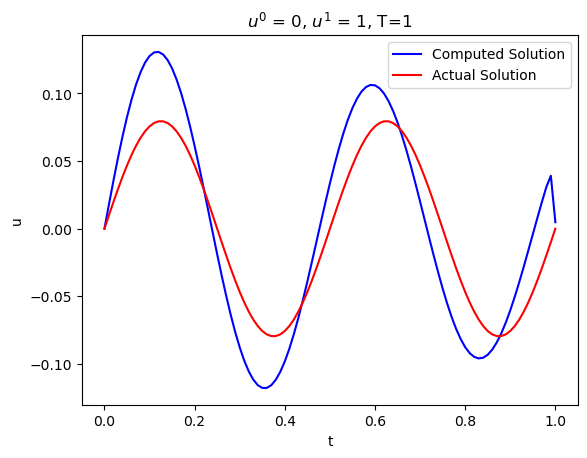

In [14]:
#Plot some outputs

t = np.linspace(0,T,101)
computed_solution = cubic_interpolant(t,dt)
plt.plot(t,computed_solution,label='Computed Solution',color='b')
plt.plot(t,true_sol(t,u0,u1,lambd),label='Actual Solution',color = 'r')
plt.legend()
plt.ylabel('u')
plt.xlabel('t')
plt.title(r"$u^0$ = {}, $u^1$ = {}, T={}".format(u0,u1,T))
